In [1]:
import gc
import pandas as pd
import scipy.sparse as sps

In [2]:
valid=sps.load_npz("./dressipi_dataset/URM_valid_bought.npz")
bought=valid.indices

In [3]:
dataset=None
dataset_max=None
#["UCF","ICBF","ICF","Graph","TopPop100","TopPop50","TopPop15"]
for file in ["UCF","ICBF","Graph","ICF"]:
    print(gc.collect())
    print(f"loading {file}")
    df=pd.read_csv(f"./dressipi_top100_candidates/{file}.csv")
    print(len(df))
    print(f"loaded {file}")
    for col in df:
        if "Max" in col:
            df_max=df[["Session_Id",col]].drop_duplicates()
        elif "Score" in col:
            df_feats=df[["Session_Id","Item_ID",col]]
    if dataset is None:
        dataset=df_feats
        dataset_max=df_max
    else:
        dataset=dataset.merge(df_feats,on=["Session_Id","Item_ID"],how="outer")
        dataset_max=dataset_max.merge(df_max,on=["Session_Id"],how="outer")
    del df
        

#del dataset_max
del df_feats
del df_max

0
loading UCF
18588455
loaded UCF
0
loading ICBF
16931962
loaded ICBF
0
loading Graph
9381483
loaded Graph
0
loading ICF
20341641
loaded ICF


In [4]:
import ast
submission_df=pd.read_csv("./candidate-nn/last_month_candidates.csv")
submission_df["score"]=submission_df["score"].map(ast.literal_eval)
submission_df["code"]=submission_df["code"].map(ast.literal_eval)
submission_df["rank"]=submission_df["rank"].map(ast.literal_eval)
submission_df = submission_df.explode(['code','score', 'rank'])
submission_df[["session_id","code","rank"]]=submission_df[["session_id","code","rank"]].astype(int)
submission_df.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_gru","score":"score_gru"},inplace=True)

In [5]:
submission_df.head()

,Session_Id,Item_ID,score_gru,rank_gru
0,918382,3731,0.022378,1
0,918382,2332,0.017789,2
0,918382,2785,0.012271,3
0,918382,1189,0.011465,4
0,918382,4380,0.010622,5


In [6]:
import ast
submission_df_tr=pd.read_csv("./candidate-transformer/last_month_candidates_transformer.csv")
submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
submission_df_tr["code"]=submission_df_tr["code"].map(ast.literal_eval)
submission_df_tr["rank"]=submission_df_tr["rank"].map(ast.literal_eval)
submission_df_tr = submission_df_tr.explode(['code','score', 'rank'])
submission_df_tr[["session_id","code","rank"]]=submission_df_tr[["session_id","code","rank"]].astype(int)
submission_df_tr.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_transformer","score":"score_transformer"},inplace=True)

In [7]:
import ast
submission_df_LSTM=pd.read_csv("candidate-lstm/last_month_candidates_lstm_bidirectional.csv")
submission_df_LSTM["score"]=submission_df_LSTM["score"].map(ast.literal_eval)
submission_df_LSTM["code"]=submission_df_LSTM["code"].map(ast.literal_eval)
submission_df_LSTM["rank"]=submission_df_LSTM["rank"].map(ast.literal_eval)
submission_df_LSTM = submission_df_LSTM.explode(['code','score', 'rank'])
submission_df_LSTM[["session_id","code","rank"]]=submission_df_LSTM[["session_id","code","rank"]].astype(int)
submission_df_LSTM.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_LSTM","score":"score_LSTM"},inplace=True)

In [8]:
submission_df_tr.head()

,Session_Id,Item_ID,score_transformer,rank_transformer
0,918382,3678,0.091941,1
0,918382,2865,0.054434,2
0,918382,3731,0.03273,3
0,918382,513,0.019041,4
0,918382,2785,0.018662,5


In [9]:
dataset=dataset.merge(submission_df,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_tr,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_LSTM,on=["Session_Id","Item_ID"],how="outer")

dataset=dataset.merge(dataset_max,on=["Session_Id"],how="left")


In [10]:
del dataset_max
del submission_df
del submission_df_tr

In [11]:
import numpy as np
sessions=np.unique(dataset["Session_Id"])
train=pd.DataFrame()
train["Session_Id"]=sessions
train["Item_ID"]=bought
train["target"]=1

In [12]:
gc.collect()

2761

In [13]:
dataset=dataset.merge(train,on=["Session_Id","Item_ID"],how="left")
dataset.fillna(0,inplace=True)
gc.collect()

0

In [14]:
dataset["target"]=dataset["target"].astype("int8")
gc.collect()

0

In [15]:
dataset

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,score_gru,rank_gru,score_transformer,rank_transformer,score_LSTM,rank_LSTM,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,target
0,918382,78,0.515642,0.000000,0.377850,0.587459,0.001514,42.0,0.001956,79.0,0.001662,81.0,60.744503,3.067216,1.982604,0.395666,0
1,918382,178,0.281229,0.000000,0.142546,0.412063,0.000000,0.0,0.000000,0.0,0.000000,0.0,60.744503,3.067216,1.982604,0.395666,0
2,918382,230,0.127506,0.000000,0.055109,0.022295,0.000000,0.0,0.000000,0.0,0.000000,0.0,60.744503,3.067216,1.982604,0.395666,0
3,918382,242,0.395681,0.775898,0.273503,0.514097,0.002653,26.0,0.009070,12.0,0.003761,33.0,60.744503,3.067216,1.982604,0.395666,0
4,918382,292,0.200113,0.601746,0.105606,0.458708,0.000000,0.0,0.000000,0.0,0.000000,0.0,60.744503,3.067216,1.982604,0.395666,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42815990,999999,2316,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.001413,89.0,111.366875,9.421845,12.826448,0.786831,0
42815991,999999,3252,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.001411,90.0,111.366875,9.421845,12.826448,0.786831,0
42815992,999999,2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.001351,97.0,111.366875,9.421845,12.826448,0.786831,0
42815993,999999,3133,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.001344,98.0,111.366875,9.421845,12.826448,0.786831,0


In [16]:
sessions_containing_bought_among_candidates=dataset[["Session_Id","target"]].groupby("Session_Id").agg(sum).reset_index()
sessions_containing_bought_among_candidates=sessions_containing_bought_among_candidates.loc[sessions_containing_bought_among_candidates["target"]>0]

dataset=dataset[dataset['Session_Id'].isin(sessions_containing_bought_among_candidates["Session_Id"].tolist())]

In [17]:
dataset.head(20)

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,score_gru,rank_gru,score_transformer,rank_transformer,score_LSTM,rank_LSTM,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,target
209,918383,55,0.054177,0.632362,0.005355,0.018442,0.000000,0.0,0.000000,0.0,0.001609,47.0,594.02826,7.204127,91.79825,1.092114,0
210,918383,122,0.025767,0.000000,0.000000,0.000000,0.000390,90.0,0.000000,0.0,0.000000,0.0,594.02826,7.204127,91.79825,1.092114,0
211,918383,189,0.129413,0.000000,0.020602,0.278846,0.001349,28.0,0.003134,35.0,0.000850,77.0,594.02826,7.204127,91.79825,1.092114,0
212,918383,215,0.036236,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,594.02826,7.204127,91.79825,1.092114,0
213,918383,260,0.039900,0.000000,0.003595,0.012055,0.000000,0.0,0.000000,0.0,0.000000,0.0,594.02826,7.204127,91.79825,1.092114,0
214,918383,320,0.040230,0.000000,0.000000,0.000000,0.001628,22.0,0.004717,25.0,0.003327,28.0,594.02826,7.204127,91.79825,1.092114,0
215,918383,357,0.040280,0.000000,0.003286,0.012149,0.000000,0.0,0.000000,0.0,0.000638,97.0,594.02826,7.204127,91.79825,1.092114,0
216,918383,379,0.046153,0.637329,0.004070,0.016121,0.000387,92.0,0.000000,0.0,0.001490,52.0,594.02826,7.204127,91.79825,1.092114,0
217,918383,421,0.064009,0.604249,0.013832,0.319644,0.000000,0.0,0.000823,97.0,0.000000,0.0,594.02826,7.204127,91.79825,1.092114,0
218,918383,506,0.032975,0.493767,0.003990,0.017444,0.000000,0.0,0.001294,69.0,0.000000,0.0,594.02826,7.204127,91.79825,1.092114,0


In [18]:
# dataset_macro_features = pd.read_csv('./macro-feats/train_with_macro_feats.csv',
#                                      usecols=['session_id',
#                                                 'session_similarity',
#                                                 'session_similarity_uniques', 'session_similarity_feats', 'session_similarity_feats_uniques',
#                                               'length_of_session_seconds',
#                    'avg_time_spent_per_item_seconds',
#                    'variance_time_spent_per_item_seconds',
#                    'n_seen_items',
#                    'n_unique_items',])
#
# dataset_macro_features.rename(columns={'session_id':'Session_Id'}, inplace=True)
# dataset = dataset.merge(dataset_macro_features, on='Session_Id', how='left')

In [19]:
dataset.drop(columns = ['rank_LSTM', 'rank_gru', 'rank_transformer'], axis=1, inplace=True)

/var/folders/j4/lrzvgqtj3bz3ynm2xlxsxtc00000gn/T/ipykernel_20922/2867263171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns = ['rank_LSTM', 'rank_gru', 'rank_transformer'], axis=1, inplace=True)


In [20]:
from sklearn.model_selection import train_test_split
train,valid=train_test_split(train,test_size=0.2, random_state=1234)
gc.collect()


0

In [21]:
train_sessions=train["Session_Id"].tolist()
valid_sessions=valid["Session_Id"].tolist()

In [22]:
train=dataset[dataset["Session_Id"].isin(train_sessions)]
gc.collect()
valid=dataset[dataset["Session_Id"].isin(valid_sessions)]
gc.collect()

0

In [23]:
train=train.sort_values("Session_Id")
gc.collect()
valid=valid.sort_values("Session_Id")
gc.collect()

0

In [24]:
qids_train = train[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
print(len(qids_train)/0.8)
gc.collect()
qids_valid = valid[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
gc.collect()

61483.75


0

In [25]:
X_train=train.drop(["target","Session_Id","Item_ID"],axis=1)
gc.collect()
y_train=train["target"]
gc.collect()
X_valid=valid.drop(["target","Session_Id","Item_ID"],axis=1)
gc.collect()
y_valid=valid["target"]

In [26]:
gc.collect()

0

In [27]:
import lightgbm

In [28]:
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    #objective="rank_xendcg",
    #metric="mrr",
    n_estimators=2000,
    lambdarank_truncation_level=103,
    reg_alpha=1e-4,
    learning_rate=0.05,
    min_child_samples=600,
    subsample=0.6,
    subsample_freq=10
    
)

In [29]:
ranker=model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_valid, y_valid)],
    eval_group=[qids_valid],
    eval_at=(100),
    callbacks=[lightgbm.log_evaluation(),lightgbm.early_stopping(50,first_metric_only=True)],
    #verbose=10,
    eval_metric=["map","ndcg"]
)


[1]	valid_0's map@100: 0.149395	valid_0's ndcg@100: 0.269112
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@100: 0.225528	valid_0's ndcg@100: 0.331132
[3]	valid_0's map@100: 0.232471	valid_0's ndcg@100: 0.337168
[4]	valid_0's map@100: 0.23577	valid_0's ndcg@100: 0.340209
[5]	valid_0's map@100: 0.236357	valid_0's ndcg@100: 0.340897
[6]	valid_0's map@100: 0.237519	valid_0's ndcg@100: 0.341778
[7]	valid_0's map@100: 0.238205	valid_0's ndcg@100: 0.342421
[8]	valid_0's map@100: 0.239207	valid_0's ndcg@100: 0.343224
[9]	valid_0's map@100: 0.239787	valid_0's ndcg@100: 0.343669
[10]	valid_0's map@100: 0.240006	valid_0's ndcg@100: 0.343883
[11]	valid_0's map@100: 0.240443	valid_0's ndcg@100: 0.344161
[12]	valid_0's map@100: 0.240018	valid_0's ndcg@100: 0.343927
[13]	valid_0's map@100: 0.240105	valid_0's ndcg@100: 0.344092
[14]	valid_0's map@100: 0.240167	valid_0's ndcg@100: 0.344185
[15]	valid_0's map@100: 0.240361	valid_0's ndcg@100: 0.344437
[16]	valid_0's map@

In [30]:
print(len(qids_train))

49187


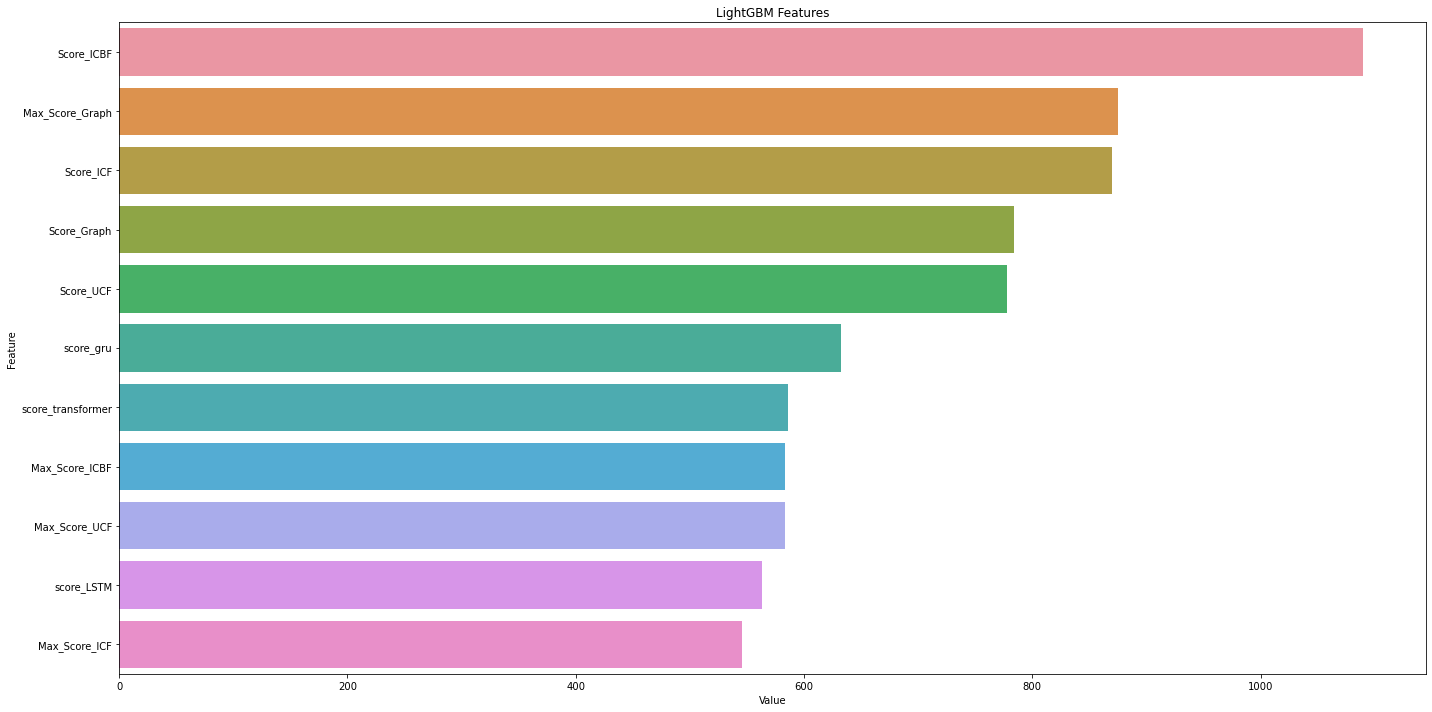

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(ranker.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [32]:
ranker.booster_.save_model('ranker_NN_transformer_LSTM_no_ranks.txt')